<a href="https://colab.research.google.com/github/Repa235/Notebook_ML_BankNotes/blob/main/Bank_notes_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrizione del dataset e del task


il dataset è reperibile ai seguenti link in formato [csv](https://www.kaggle.com/ritesaluja/bank-note-authentication-uci-data) e [txt](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)

I dati sono stati estratti da immagini prese da campioni simili di banconote autentiche e contraffatte. 

Per la digitalizzazione è stata utilizzata una fotocamera industriale solitamente usata per l'ispezione di questo tipo di banconote. Le immagini finali hanno una dimensione di 400x400 pixel. A causa della lente dell'oggetto e della distanza dall'oggetto di indagine, sono state ottenute immagini in scala di grigi con una risoluzione di circa 660 dpi. Per estrarre le caratteristiche dalle immagini è stato usato lo strumento trasformazione delle lughezze d'onda.

Il dataset è costituito da colonne che rappresentano:


1. Variance o Varianza:  rappresenta una misura del contrasto presente in un’immagine, valori continui.
2. Skewness o Asimmetria: valori continui. 
3. Curtosis o Curtosi, misura quanto l'immagine si discosta dalle normali immagini di quel tipo, valori continui.
4. Entropy o Entropia: quantità di informazioni che possono essere estratte da un immagine, tanto più alta sarà l'entropia, tante più informazioni potranno essere tratte dall'immagine, valori continui. 
5. Class o Classe (Target): rappresenta se una banconota è autentica o meno, valori discreti, rispettivamente: 1 per le banconote autentiche e 0 per quelle contraffatte.

**Obiettivo:** realizzare un classificatore binario che discrimina le banconote autentiche da quelle contraffatte.



# Presentazione dei dati



##Librerie utilizzate per i dati


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
 

from sklearn.metrics import *
from mlxtend.plotting import *

## Librerie utilizzate per gli algoritmi di machine learning

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import *
from tensorflow import *
from keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dense
from tensorflow import keras

## Caricamento dataset

Come prima operazione leggiamo il dataset caricato e mostriamo le prime 5 entry attraverso il comando *head()*.

In [5]:
import os
 
filename = 'bank_notes.csv'
if os.path.isfile(filename) and os.access(filename, os.R_OK):
    print("Il file è già presente")
    df = pd.read_csv('bank_notes.csv')
else:
    print("File non trovato! Si prega di inserire il file")
    file_caricato = files.upload()
    df = pd.read_csv('bank_notes.csv')

File non trovato! Si prega di inserire il file


Saving bank_notes.csv to bank_notes.csv


In [ ]:
df.head()

,variance,skewness,curtosis,entropy,Target
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Operazioni preliminari sul dataset ed esplorazione dei dati
Traduciamo,o meglio rinominiamo, le colonne

In [7]:
df=df.rename(columns={'variance': 'Varianza', 'skewness': 'Asimmetria', 'curtosis': 'Curtosi', 'entropy': 'Entropia', 'Target': 'Autenticità' })

Verifichiamo il numero di entry

In [ ]:
df.shape

(1372, 5)

Controlliamo la presenza di dati nulli nel dataset

In [ ]:
df.isnull().sum()

Varianza       0
Asimmetria     0
Curtosi        0
Entropia       0
Autenticità    0
dtype: int64

Notiamo con piacere che il dataset non presenta celle con valori nulli, procediamo quindi con la descrizione del dataset. 

Il comando *describe()*, invece,  mostra una tabella con i dettagli di ogni colonna, in particolare:
* Il numero di entry
* la media
* lo scarto quadratico medio
* il minimo
* i quartili
* il massimo



In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Varianza,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
Asimmetria,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
Curtosi,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
Entropia,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
Autenticità,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


I grafici a seguire mostrano la distribuzione delle caratteristiche, è stato scelto di rappresentare solo le features visto che le etichette verranno analizzate in seguito.

In [8]:
columns = list(df.columns)
columns.remove('Autenticità')

Di seguito viene mostrato un confronto tra la distribuzione delle variabili delle banconote autentiche (arancione) e quelle falsificate (blu). Dai grafici emerge che il dato più significativo è la varianza in quanto vi è una separazione più netta tra le distribuzioni.

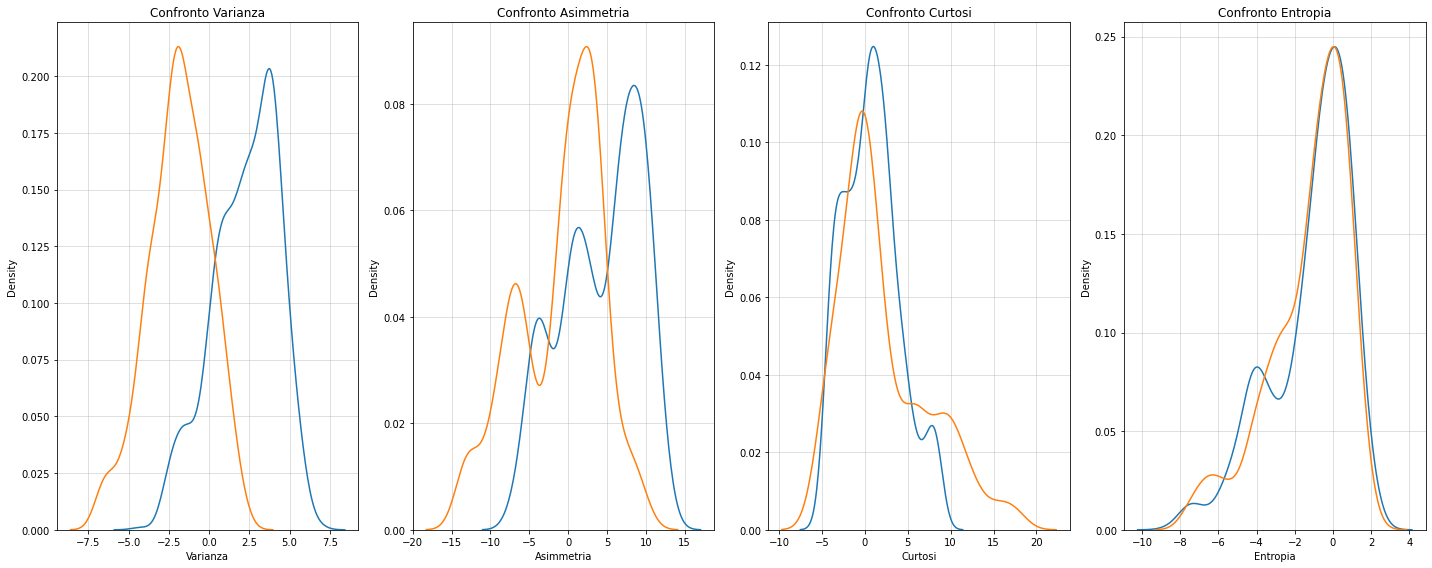

In [14]:
plt.figure(figsize = (20,8))
i = 0
for col in columns:
    plt.subplot(1,4,i+1)
    plt.grid(True, alpha =0.5)
    sns.kdeplot(df[col][df['Autenticità'] ==0], label = 'False')
    sns.kdeplot(df[col][df['Autenticità'] ==1], label = 'Originali')
    plt.title('Confronto ' + col)
    plt.tight_layout()
    i+=1
plt.show()

Dal plot precedente notriamo che: 
* varianza e asimmetria presentano una distribuzione normale 
* la curtosità presenta un'asimmetria positiva
* l'entropia presenta un'asimmetria negativa

Il plot seguente mostra invece la matrice di correlazione, rappresenta l'indice di correlazione di due colonne partendo da un minimo di -1 per le colonne correlate negativamente fino a un massimo di 1 per le colonne altamente correlate. Qualora due colonne avessero una correlazione pari a 1, una delle due potrebbe essere rimossa.

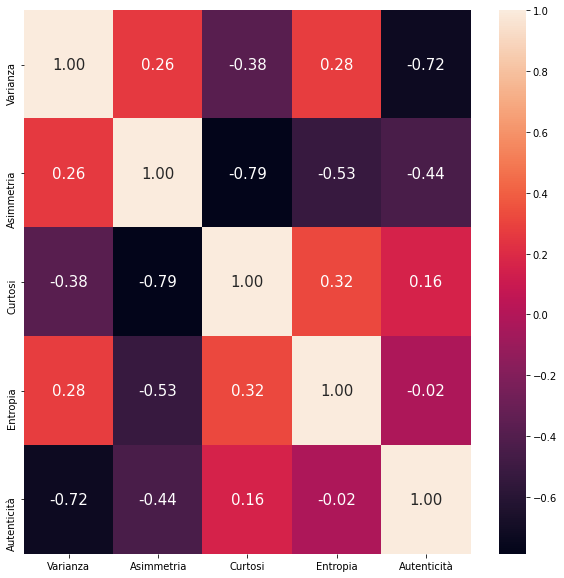

In [ ]:
matrice_correlazione = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(matrice_correlazione, cbar = True, annot=True, fmt= '.2f',annot_kws={'size': 15})



L'ultima operazione che andiamo a svolgere è il conteggio delle etichette, ossia il numero di banconote autentiche (indicate con 1) e di quelle false (indicate con 0).

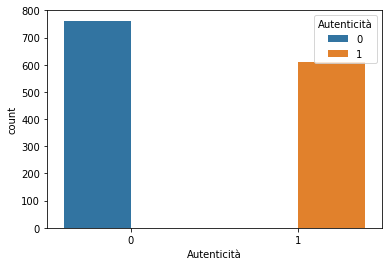

Numero vere:  610
Numero false:  762


In [ ]:
banconote_vere = len(df.loc[df['Autenticità'] == 1])
banconote_false = len(df.loc[df['Autenticità']== 0])
sns.countplot(x='Autenticità', hue='Autenticità', data=df)
plt.show()
print('Numero vere: ', banconote_vere)
print('Numero false: ', banconote_false)

## Separazione del dataset

Passiamo ora a dividere il nostro dataset in due subset, il dataset verrà suddiviso con un rapporto di 80-20

In [ ]:
from sklearn.model_selection import train_test_split
features = ['Varianza', 'Asimmetria', 'Curtosi', 'Entropia']
target = ['Autenticità']
X=df[features]
y=df[target]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
print('Dimensione training set',len(X_train)) 
print('Dimensione test set',len(X_test))

Dimensione training set 960
Dimensione test set 412


# Algoritmi di machine learning

Gli algoritmi utilizzati sono:


*   Regressione logistica
*   K-Neighbours
*   Support vector machines con kernel gaussiano, polinomiale (con variabili di slack) e lineare



## Regressione logistica

In [ ]:
rl = LogisticRegression()
rl.fit(X_train,y_train.values.ravel())
rl_pred = rl.predict(X_test)
rl_acc = accuracy_score(y_test, rl_pred)

In [ ]:
print('Accuratezza : ', '{:.2f}%'.format(100 * rl_acc))

Accuratezza :  99.03%


In [ ]:
print(classification_report(y_test, rl_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       233
           1       0.98      1.00      0.99       179

    accuracy                           0.99       412
   macro avg       0.99      0.99      0.99       412
weighted avg       0.99      0.99      0.99       412



<Figure size 432x288 with 0 Axes>

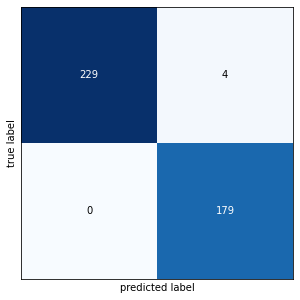

In [ ]:
cm = confusion_matrix(y_test, rl_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

## K-neighbours

In [ ]:
kn = KNeighborsClassifier(n_neighbors=4)
kn.fit(X_train,y_train.values.ravel())
kn_pred = kn.predict(X_test)
kn_acc = accuracy_score(y_test,kn_pred)

In [ ]:
print('Accuratezza : ', '{:.2f}%'.format(100 * kn_acc))

Accuratezza :  100.00%


In [ ]:
print(classification_report(y_test, kn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00       179

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



<Figure size 432x288 with 0 Axes>

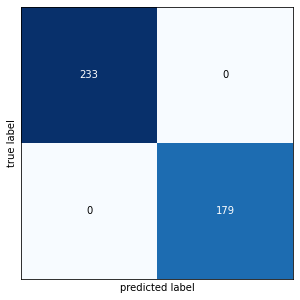

In [ ]:
cm = confusion_matrix(y_test, kn_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

## Support vector machines
Il focus è stato posto sull'utilizzo vari kernel.


### Kernel gaussiano rbf (di default)

In [ ]:
svc_rbf = SVC()
svc_rbf.fit(X_train,y_train.values.ravel())
svc_rbf_pred = svc_rbf.predict(X_test)
svc_rbf_acc = accuracy_score(y_test, svc_rbf_pred)

In [ ]:
print('Accuratezza : ', '{:.2f}%'.format(100 * svc_rbf_acc))

Accuratezza :  99.51%


In [ ]:
print(classification_report(y_test, svc_rbf_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       233
           1       0.99      1.00      0.99       179

    accuracy                           1.00       412
   macro avg       0.99      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



<Figure size 432x288 with 0 Axes>

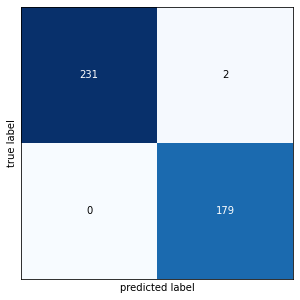

In [ ]:
cm = confusion_matrix(y_test, svc_rbf_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

### Kernel polinomiale

In [ ]:
svc_pol = SVC(kernel='poly')
svc_pol.fit(X_train,y_train.values.ravel())
svc_pol_pred = svc_pol.predict(X_test)
svc_pol_acc = accuracy_score(y_test, svc_pol_pred)

In [ ]:
print('Accuratezza : ', '{:.2f}%'.format(100 * svc_pol_acc))

Accuratezza :  96.36%


In [ ]:
print(classification_report(y_test, svc_pol_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       233
           1       0.92      1.00      0.96       179

    accuracy                           0.96       412
   macro avg       0.96      0.97      0.96       412
weighted avg       0.97      0.96      0.96       412



<Figure size 432x288 with 0 Axes>

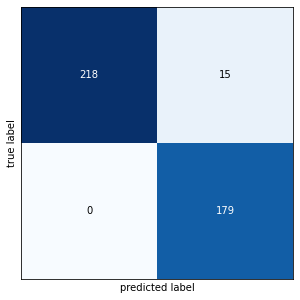

In [ ]:
cm = confusion_matrix(y_test, svc_pol_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

### Kernel lineare

In [ ]:
svc_lin = SVC(kernel='linear')
svc_lin.fit(X_train,y_train.values.ravel())
svc_lin_pred = svc_lin.predict(X_test)
svc_lin_acc = accuracy_score(y_test, svc_lin_pred)

In [ ]:
print('Accuratezza : ', '{:.2f}%'.format(100 * svc_lin_acc))

Accuratezza :  99.03%


In [ ]:
print(classification_report(y_test, svc_lin_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       233
           1       0.98      1.00      0.99       179

    accuracy                           0.99       412
   macro avg       0.99      0.99      0.99       412
weighted avg       0.99      0.99      0.99       412



<Figure size 432x288 with 0 Axes>

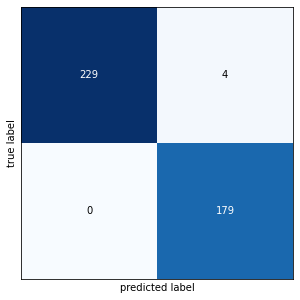

In [ ]:
cm = confusion_matrix(y_test, svc_lin_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

# Deep learning - una rete neurale 

Inizialmente realizzeremo una rete neurale con determinate caratteristiche,successivamente proveremo a ottimizzare i valori ottenuti attraverso la modifica di alcuni iperparametri e inserendo la funzione di EarlyStop. 

Come funzione di perdita è stata scela la Binary_crossentropy essendo un classificatore binario.





In [ ]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [ ]:
model= Sequential()

model.add(Dense(12, input_dim=4, activation='relu'))
model.add(Dense(8, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#early_stopping=keras.callbacks.EarlyStopping(monitor="val_loss",mode=min)
#history = model.fit(X_train, y_train, epochs=10, batch_size=10,verbose=1,validation_split=0.2, callbacks=[early_stopping])

history = model.fit(X_train, y_train, epochs=15, batch_size=10,verbose=1,validation_split=0.1)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/15
87/87 [==============================] - 1s 4ms/step - loss: 0.7422 - accuracy: 0.4051 - val_loss: 0.6356 - val_accuracy: 0.7396
Epoch 2/15
87/87 [==============================] - 0s 2ms/step - loss: 0.5690 - accuracy: 0.7755 - val_loss: 0.4634 - val_accuracy: 0.8958
Epoch 3/15
87/87 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.8854 - val_loss: 0.2980 - val_accuracy: 0.9896
Epoch 4/15
87/87 [==============================] - 0s 2ms/step - loss: 0.2784 - accuracy: 0.9375 - val_loss: 0.1690 - val_accuracy: 1.0000
Epoch 5/15
87/87 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9583 - val_loss: 0.1000 - val_accuracy: 1.0000
Epoch 6/15
87/87 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9722 - val_loss: 0.0671 - val_accuracy: 1.0000
Epoch 7/15
87/87 [==============================] - 0s 2ms/step - loss: 0.0918 - accuracy: 0.9780 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 8/15
87/87 [==

In [ ]:
train_loss = history.history['loss']
val_loss = history.history ['val_loss']
train_acc = history.history ['accuracy']
val_acc = history.history ['val_accuracy']

Text(0.5, 1.0, 'Accuratezza training e validation')

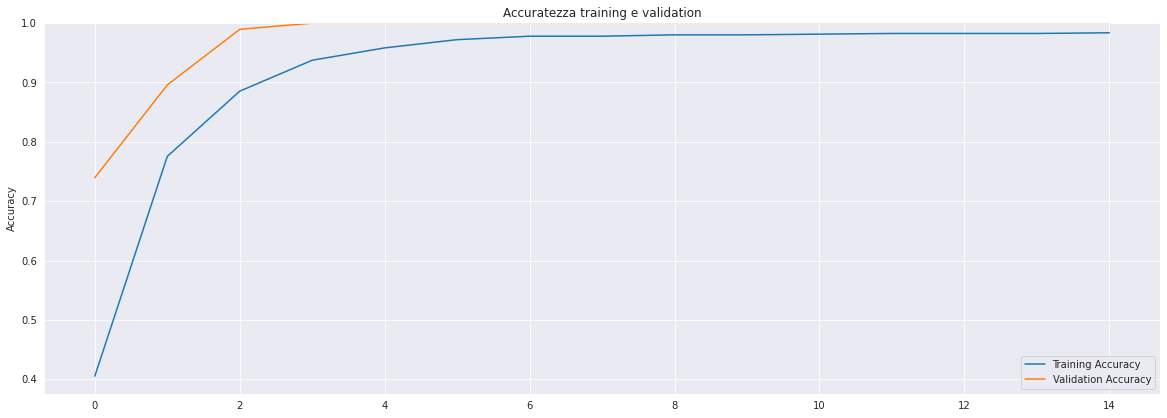

In [ ]:
plt.figure (figsize=(20,15))
plt.subplot(2,1,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuratezza training e validation')

Text(0.5, 1.0, 'Loss di training e validation')

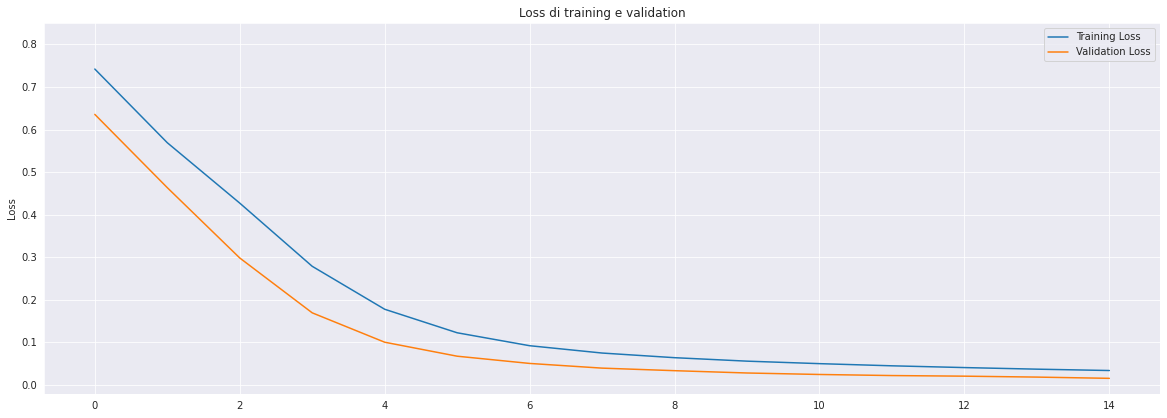

In [ ]:
plt.figure (figsize=(20,15))
plt.subplot(2,1,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),0.85])
plt.title('Loss di training e validation')


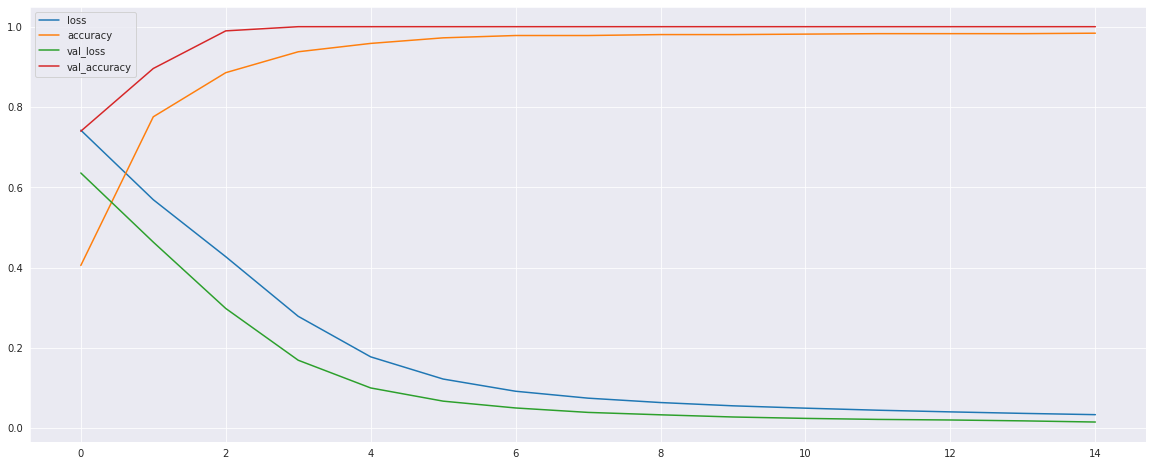

In [ ]:
hgraph=pd.DataFrame(history.history)
hgraph.plot()

Visto e considerato che il sistema produce degli ottimi risultati dopo un numero modesto di epoche è stato deciso di non utilizzare l'early stopping (lasciato nella parte commentata del codice) nè di modificare parametri.  

# Confronto tra i vari modelli

Concludiamo confrontando l'accuratezza dei vari modelli ottenuti:

In [ ]:
lista_modelli = ['Regressione Logistica', 'SVC-rbf', 'SVC-poly', 'SVC-linear','KNearestNeighbours', 'Rete neurale']
lista_accuratezze=[rl_acc*100, svc_rbf_acc*100, svc_pol_acc*100, svc_lin_acc*100, kn_acc*100, accuracy*100]

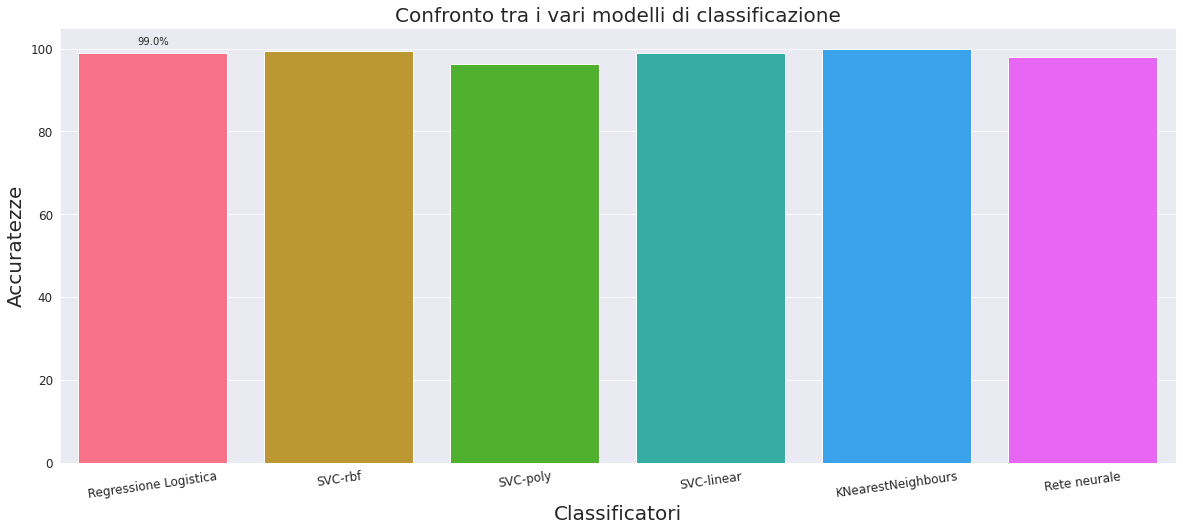

In [ ]:
plt.rcParams['figure.figsize'] = 20, 8
sns.set_style('darkgrid')
ax = sns.barplot(x=lista_modelli, y=lista_accuratezze, palette = 'husl', saturation=2.0)
plt.xlabel('Classificatori', fontsize=20)
plt.ylabel('Accuratezze', fontsize=20)
plt.title('Confronto tra i vari modelli di classificazione', fontsize=20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height, 2)}%', ( x + width/2, y + height* 1.02), ha='center')
    plt.show()

Fortunatamente tutti i modelli prodotti presentano un'accuratezza abbastanza elevata, spicca particolarmente il k-nearest neighbours con un'accuratezza del 100%